# Co-occurance friendship

In [325]:
import pandas as pd
import feather as ft
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyitlib import discrete_random_variable as drv
from math import log, e
from scipy.stats import entropy
import h5py
import time
import pickle
import networkx as nx

## Data processing

In [3]:
""" Data pre-processing """
# df_full = dd.read_csv("data/weeplace_checkins.csv")
# # df_full = df_full.dropna(subset=["placeid"])
# df_full = pd.read_csv("data/weeplace_checkins.csv")
# # df_full = df_full.dropna(subset=["placeid"])
# # full dataset only removing NA location
# df_full = ft.read_dataframe('data/weeplace_checkins_without_loc_NA.feather')

# make new dataframe removing minutes and seconds information, called df_hour
# df_full['datetime'] = dd.to_datetime(df_full['datetime']).dt.floor('H')
# df_full['datetime'] = pd.to_datetime(df_full['datetime']).dt.floor('H')
# ft.write_dataframe(df_full, 'data/weeplace_checkins_hour_without_loc_NA.feather')
# # full dataset removing NA location and group the time into 1-hour bin
df_hour = ft.read_dataframe('data/weeplace_checkins_hour_without_loc_NA.feather')
df_friend = pd.read_csv('data/weeplace_friends.csv')

## Co-occurance detection

In [5]:
username = df_hour['userid'].unique().tolist()
N_users = len(username)

# start_time = time.time()
# # allocate space for object array
# meetup_store = np.empty(N_users, dtype=object)

# counter = 1
# for id in username[0:20]:
#     ego = df_hour[df_hour['userid'] == id][['userid', 'placeid', 'datetime']]
#     alter = df_hour[df_hour['userid']!=id][['userid', 'placeid', 'datetime']]
    
#     meetup = ego.merge(alter, how='left', on =['placeid', 'datetime'])\
#     .dropna()[['userid_x','placeid', 'userid_y']].groupby(['userid_x','userid_y'])['placeid']\
#     .count().reset_index(name='count').sort_values('count', ascending=False)
    
#     meetup[['percent']] = meetup[['count']]/meetup['count'].sum()
#     meetup_store[username.index(id)]=meetup
# #     names = 'user' + str(counter)
# #     meetup.to_hdf('meetup.h5', key=names, mode='a', complib ='blosc:zstd',complevel=9)
# #     print(counter)
#     counter += 1


# # save pickle file
# pickle_out = open("meetup_store.pickle", "wb")
# pickle.dump(meetup_store, pickle_out)
# pickle_out.close()

# elapsed_time = time.time() - start_time


# read picle file
pickle_in = open("meetup_store.pickle", "rb")
meetup_store = pickle.load(pickle_in)

## Check how many friends the users general have

### Elements check between two sources

In [74]:
TrueUser1 = set(df_friend['userid1'].tolist())
TrueUser2 = set(df_friend['userid2'].tolist())
UsedUser = set(df_hour['userid'].tolist())

if UsedUser.issubset(TrueUser1) & UsedUser.issubset(TrueUser2):
    print('All used users appear in the true friendship network')

All used users appear in the true friendship network


In [79]:
print(len(list(TrueUser1 - UsedUser)))   # Users in userid1 but not appear in our used checkin dataset 

228


In [80]:
print(len(list(TrueUser2 - UsedUser)))   # Users in userid2 but not appear in our used checkin dataset 

229


### Know something about friendship 

In [103]:
# The number of friend in the true friendship nework
NT_friend = df_friend.groupby('userid1').count()['userid2'].reset_index(name='count').sort_values('count', ascending=False)
NT_friend

,userid1,count
6044,huffpost,1685
12974,robert-scoble,822
4503,elavrov,707
14162,standard-hotels,445
12630,red-bull,334
...,...,...
10796,michael-sutton-long,1
6912,jenn-b,1
6915,jenn-davis,1
3528,daniel-goodall,1


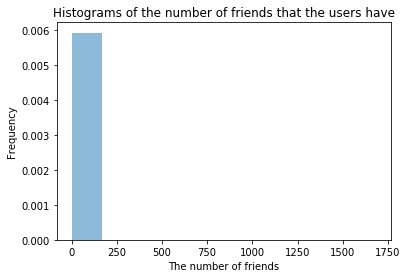

In [124]:
plt.title('Histograms of the number of friends that the users have')
plt.xlabel('The number of friends')
plt.ylabel('Frequency')
plt.hist(NT_friend['count'],density = True, alpha=.5)
plt.show()

In [189]:
# check quantile of true friendship network
pd.DataFrame(NT_friend['count']).quantile([0.1, 0.2, 0.25, 0.5, 0.75, 0.9])

,count
0.10,1.0
0.20,2.0
0.25,2.0
0.50,4.0
0.75,8.0
0.90,16.0


### Start to think our artificial friendship

As shown in the privious, we can see that 90% users have at most 16 friends, now we would like to use the number of co-occurance to infer the friendship network, called Artificial Friendship network

In [136]:
NA_meetup = [meetup_store[x]['count'].sum() for x in range(N_users)]

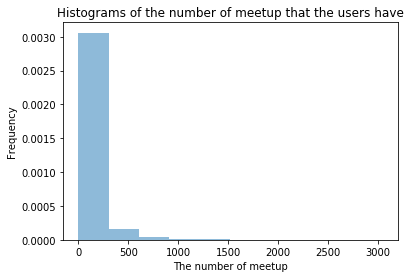

In [123]:
plt.title('Histograms of the number of meetup that the users have')
plt.xlabel('The number of meetup')
plt.ylabel('Frequency')
plt.hist(NA_meetup,density = True, alpha=.5)
plt.show()

In [190]:
# check quantile of meetup
pd.DataFrame(NA_meetup, columns=['count']).quantile([0.1, 0.2,  0.25, 0.5, 0.75, 0.9])

,count
0.10,1.0
0.20,3.0
0.25,5.0
0.50,21.0
0.75,77.0
0.90,220.0


#### Artificial Friendship (AF) definition 1 : fixed percentage alters

#####  Assumption 1 : Every user in our used dataset should have at least one friend.
The percentage of meetup alters should be fixed percentage of friend, we set it as Artificial Friend Rate (AFR), firstly, we set

In [431]:
# AFR = 0.07 ceil function + 1
def AFR(x, mode):
    switcher = {
        'all' : x,
        'threshold' : 1 if x<=2 else math.ceil(0.07*x) + 1,        
    }
    return switcher.get(mode)


# def AFR(x, **kwargs):
#     if 'all' in kwargs:   #  """ ARF definition 2"""
#         return x
#     elif x <=2:     #     """ ARF definition 1"""
#         return 1
#     else:
#         return math.ceil(0.07*x) + 1
    
test = [3, 5, 21, 77, 220]
for i in test:
    print(AFR(i, 'threshold'), AFR(i, 'all'))

2 3
2 5
3 21
7 77
17 220


If we can have more accurate estimation of AFR, we may achieve better network

In [428]:
def meetup_to_friend(userid_num, mode):
    """  return the alters who the friends of ego based on AFR criteria  """
    N_meetup = meetup_store[userid_num]['count'].sum()
    threshold = AFR(N_meetup, mode)
    alter = meetup_store[userid_num].head(threshold).reset_index(drop=True)
    return alter

In [429]:
# Construct all AF network details 
AR_network = pd.concat([meetup_to_friend(x, 'threshold') for x in range(N_users)])

In [432]:
AR_network

,userid_x,userid_y,count,percent
0,fred-wilson,andrew-parker,10,0.035088
1,fred-wilson,bijan-sabet,6,0.021053
2,fred-wilson,caroline-mccarthy,5,0.017544
3,fred-wilson,mark-g,5,0.017544
4,fred-wilson,eric-spiegelman,4,0.014035
...,...,...,...,...
3,simon-colijn,maarten-scheer,1,0.027778
0,mark-van-der-poel,simon-colijn,22,0.733333
1,mark-van-der-poel,rene-sijnke,5,0.166667
2,mark-van-der-poel,celine-lucas,1,0.033333


In [433]:
# save artificial friendship network with threshold 
AR_network.to_csv('data/weeplace_artifical_friend_threshold.csv', index=False)

In [434]:
# save artificial friendship network with threshold only for graph-tool 
AR_network[['userid_x', 'userid_y']].to_csv('data/weeplace_artifical_friend_threshold_gt.csv', index=False)

#### Artificial Friendship (AF) definition 2 : all meetup alters

In [435]:
# Construct all AF_all network details 
AR_network_all = pd.concat([meetup_to_friend(x, 'all') for x in range(N_users)])

In [436]:
AR_network_all

,userid_x,userid_y,count,percent
0,fred-wilson,andrew-parker,10,0.035088
1,fred-wilson,bijan-sabet,6,0.021053
2,fred-wilson,caroline-mccarthy,5,0.017544
3,fred-wilson,mark-g,5,0.017544
4,fred-wilson,eric-spiegelman,4,0.014035
...,...,...,...,...
0,mark-van-der-poel,simon-colijn,22,0.733333
1,mark-van-der-poel,rene-sijnke,5,0.166667
2,mark-van-der-poel,celine-lucas,1,0.033333
3,mark-van-der-poel,jordi-wiegerink,1,0.033333


In [437]:
# save artificial friendship network with threshold 
AR_network_all.to_csv('data/weeplace_artifical_friend_all.csv', index=False)
# save artificial friendship network with threshold only for graph-tool 
AR_network_all[['userid_x', 'userid_y']].to_csv('data/weeplace_artifical_friend_all_gt.csv', index=False)

### Analysis for different friendship network

In [469]:
import seaborn as sns

In [459]:
adj_similarity = pd.DataFrame.from_dict({
    'TF': [1, 0.009080255219410565, 0.008505080190397247],
    'AFR-T': [0.009080255219410565, 1, 0.013178097513854289],
    'AFR-A': [0.008505080190397247, 0.013178097513854289, 1]
},
orient='index', columns=['TF', 'AFR-T', 'AFR-A'])

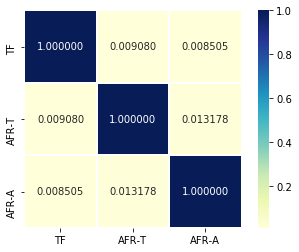

In [476]:
ax = sns.heatmap(adj_similarity,annot=True,linewidths=1,cmap="YlGnBu", fmt='f', square=True)
ax.set_aspect("equal")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [411]:
# x = 0
# for i in C1:
#     if i not in D1:
#         temp1 = AR_network[AR_network['userid_x'] == i]['userid_y'].tolist()
#         temp2 = AR_network[AR_network['userid_y'] == temp1[0]]['userid_x'].tolist()
#         if len(temp2)==1 & (temp1[0] not in AR_network['userid_x'].tolist()):
#             x +=1
#             print(i, temp1[0])